# Clustering
Clustering of unlabeled data can be performed with the module `sklearn.cluster`.

Each clustering algorithm comes in two variants: a class, that implements the `fit` method to learn the clusters on train data, and a function, that, given train data, returns an array of integer labels corresponding to the different clusters. For the class, the labels over the training data can be found in the `labels_` attribute.

## K-means
The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares (see below). This algorithm requires the number of clusters to be specified. It scales well to large number of samples and has been used across a large range of application areas in many different fields.

The k-means algorithm divides a set of $N$ samples $X$ into $K$ disjoint clusters $C$, each described by the mean $\mu_j$ of the samples in the cluster. The means are commonly called the cluster “centroids”; note that they are not, in general, points from $X$, although they live in the same space.

The K-means algorithm aims to choose centroids that _minimise_ the **inertia**, or **within-cluster sum-of-squares criterion**:
$$
\sum_{i=0}^n\min_{\mu_j\in C}(||x_i-\mu_j||^2)
$$

Inertia can be recognized as a measure of how internally coherent clusters are. It suffers from various drawbacks:

- Inertia makes the assumption that clusters are convex and isotropic, which is not always the case. It responds poorly to elongated clusters, or manifolds with irregular shapes.
- Inertia is not a normalized metric: we just know that lower values are better and zero is optimal. But in very high-dimensional spaces, Euclidean distances tend to become inflated (this is an instance of the so-called _“curse of dimensionality”_). Running a dimensionality reduction algorithm such as Principal component analysis (**PCA**) prior to k-means clustering can alleviate this problem and speed up the computations.

K-means is often referred to as Lloyd’s algorithm. In basic terms, the algorithm has three steps. The first step chooses the initial centroids, with the most basic method being to choose $k$ samples from the dataset $X$. After initialization, K-means consists of looping between the two other steps. The first step assigns each sample to its nearest centroid. The second step creates new centroids by taking the mean value of all of the samples assigned to each previous centroid. The difference between the old and the new centroids are computed and the algorithm repeats these last two steps until this value is less than a threshold. In other words, it repeats until the centroids do not move significantly.


K-means is equivalent to the expectation-maximization algorithm with a small, all-equal, diagonal covariance matrix.

The algorithm can also be understood through the concept of Voronoi diagrams. First the Voronoi diagram of the points is calculated using the current centroids. Each segment in the Voronoi diagram becomes a separate cluster. Secondly, the centroids are updated to the mean of each segment. The algorithm then repeats this until a stopping criterion is fulfilled. Usually, the algorithm stops when the relative decrease in the objective function between iterations is less than the given tolerance value. This is not the case in this implementation: iteration stops when centroids move less than the tolerance.

Given enough time, K-means will always converge, however this may be to a local minimum. This is highly dependent on the initialization of the centroids. As a result, the computation is often done several times, with different initializations of the centroids. One method to help address this issue is the k-means++ initialization scheme, which has been implemented in scikit-learn (use the `init='k-means++'` parameter). This initializes the centroids to be (generally) distant from each other, leading to probably better results than random initialization, as shown in the reference.

K-means++ can also be called independently to select seeds for other clustering algorithms, see sklearn.cluster.kmeans_plusplus for details and example usage.

The algorithm supports sample weights, which can be given by a parameter sample_weight. This allows to assign more weight to some samples when computing cluster centers and values of inertia. For example, assigning a weight of 2 to a sample is equivalent to adding a duplicate of that sample to the dataset $X$.

K-means can be used for vector quantization. This is achieved using the transform method of a trained model of KMeans.

### K-means Example - Demonstration of k-means assumptions
This example is meant to illustrate situations where k-means will produce unintuitive and possibly unexpected clusters. In the first three plots, the input data does not conform to some implicit assumption that k-means makes and undesirable clusters are produced as a result. In the last plot, k-means returns intuitive clusters despite unevenly sized blobs.

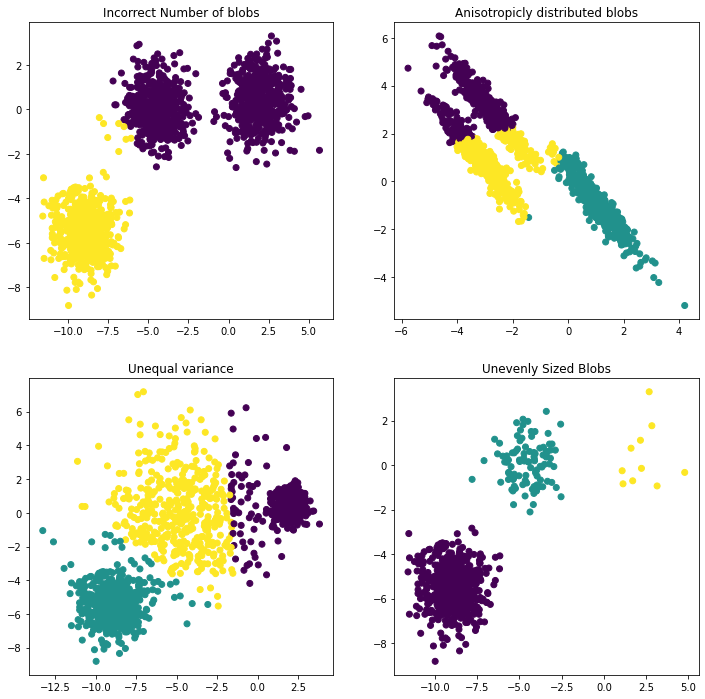

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.figure(figsize=(12,12))

n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

# Incorrect number of clusters
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)

plt.subplot(221)
plt.scatter(X[:,0], X[:,1], c=y_pred)
plt.title("Incorrect Number of blobs")

# Anisotropicly distributed data
# transform data by multiplying transformation with X
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]] 
X_aniso = np.dot(X, transformation)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)

plt.subplot(222)
plt.scatter(X_aniso[:,0], X_aniso[:,1], c=y_pred)
plt.title("Anisotropicly distributed blobs")

# Different variance
X_varied, y_varied = make_blobs(n_samples=n_samples,
                                cluster_std=[1.0,2.5,0.5], random_state=random_state)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)

plt.subplot(223)
plt.scatter(X_varied[:,0], X_varied[:,1], c=y_pred)
plt.title("Unequal variance")

# Unevenly sized blobs
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_filtered)

plt.subplot(224)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
plt.title("Unevenly Sized Blobs")

plt.show()
